<a href="https://colab.research.google.com/github/sarjakpatel/CMPE_297_Advanced_Deep_Learning/blob/main/Assignment%203/CMPE_297_Assignment_3_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE 297 Assignment 3 Part 2: Transfer Learning

## Importing Libraries

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd

## Data Preprocessing

In [108]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [109]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


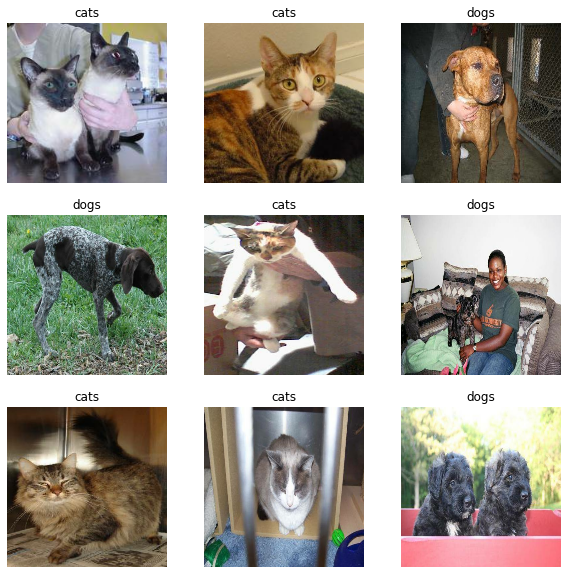

In [110]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [111]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [112]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [113]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [114]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

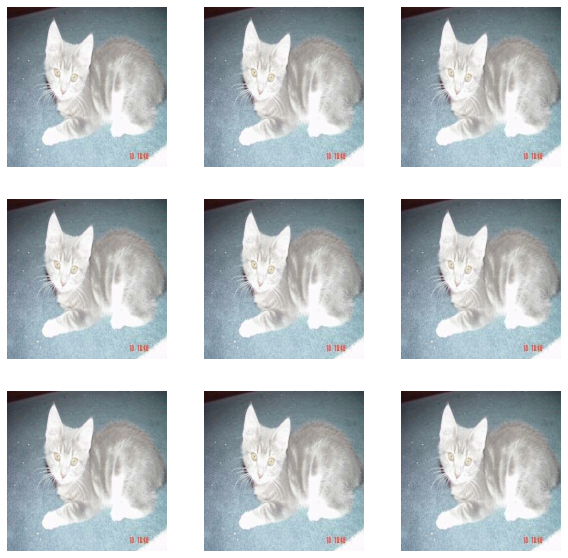

In [115]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [116]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [117]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Building the Model

In [118]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [119]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [120]:
base_model.trainable = False

In [121]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [122]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [123]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [124]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [125]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [126]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [127]:
len(model.trainable_variables)

2

## Training a Model

In [128]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 35ms/step - loss: 0.7501 - accuracy: 0.5421


In [129]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.54


In [100]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 8s 81ms/step - loss: 0.8922 - accuracy: 0.4415 - val_loss: 0.6920 - val_accuracy: 0.5965
Epoch 2/20
63/63 [==============================] - 5s 81ms/step - loss: 0.6653 - accuracy: 0.6020 - val_loss: 0.4938 - val_accuracy: 0.7438
Epoch 3/20
63/63 [==============================] - 5s 80ms/step - loss: 0.5137 - accuracy: 0.7405 - val_loss: 0.3631 - val_accuracy: 0.8490
Epoch 4/20
63/63 [==============================] - 5s 82ms/step - loss: 0.4361 - accuracy: 0.7885 - val_loss: 0.2930 - val_accuracy: 0.8948
Epoch 5/20
63/63 [==============================] - 5s 79ms/step - loss: 0.3749 - accuracy: 0.8365 - val_loss: 0.2394 - val_accuracy: 0.9171
Epoch 6/20
63/63 [==============================] - 5s 81ms/step - loss: 0.3331 - accuracy: 0.8525 - val_loss: 0.2060 - val_accuracy: 0.9295
Epoch 7/20
63/63 [==============================] - 5s 80ms/step - loss: 0.3023 - accuracy: 0.8605 - val_loss: 0.1851 - val_accuracy: 0.9418
Epoch 8/20
63

## Model Evaluation

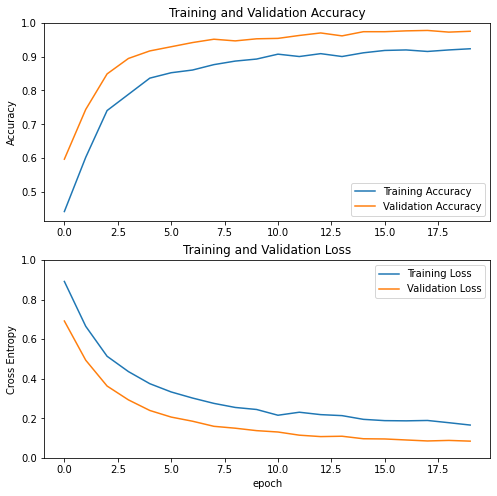

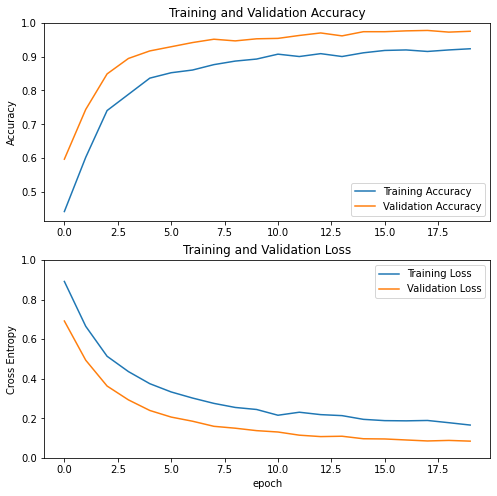

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Model Tuning

In [131]:
base_model.trainable = True

In [132]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154
Number of layers in the base model:  154


In [133]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [134]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [135]:
len(model.trainable_variables)

56

56

In [136]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40
63/63 [==============================] - 12s 105ms/step - loss: 0.2858 - accuracy: 0.8605 - val_loss: 0.0737 - val_accuracy: 0.9790
Epoch 21/40
63/63 [==============================] - 6s 91ms/step - loss: 0.1385 - accuracy: 0.9485 - val_loss: 0.1009 - val_accuracy: 0.9530
Epoch 22/40
63/63 [==============================] - 6s 91ms/step - loss: 0.1268 - accuracy: 0.9470 - val_loss: 0.0637 - val_accuracy: 0.9703
Epoch 23/40
63/63 [==============================] - 6s 91ms/step - loss: 0.0973 - accuracy: 0.9585 - val_loss: 0.0524 - val_accuracy: 0.9765
Epoch 24/40
63/63 [==============================] - 6s 92ms/step - loss: 0.0933 - accuracy: 0.9585 - val_loss: 0.0405 - val_accuracy: 0.9814
Epoch 25/40
63/63 [==============================] - 6s 91ms/step - loss: 0.1012 - accuracy: 0.9595 - val_loss: 0.0427 - val_accuracy: 0.9827
Epoch 26/40
63/63 [==============================] - 7s 100ms/step - loss: 0.0911 - accuracy: 0.9620 - val_loss: 0.0502 - val_accuracy: 0.9765
Epo

In [137]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

## Model re-evaluation

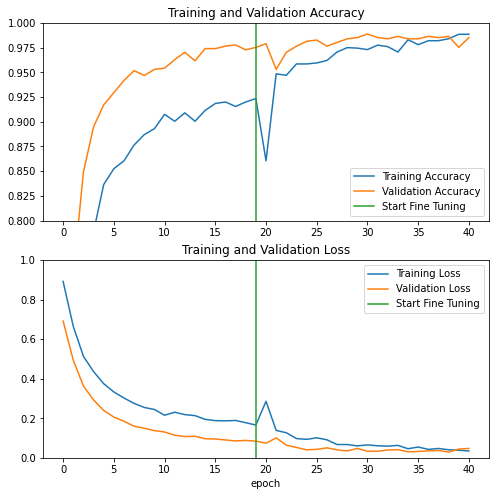

In [138]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Testing a Model

In [139]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 49ms/step - loss: 0.0565 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0]
Labels:
 [1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0]


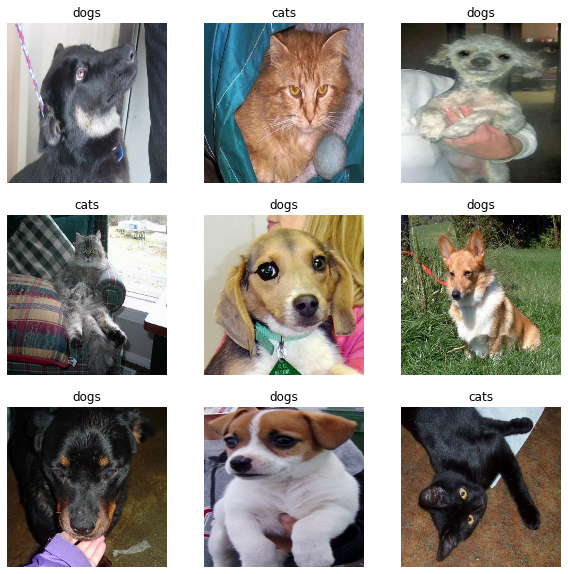

In [140]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")